**Table of contents**<a id='toc0_'></a>    
- [文件说明（File descriptions）](#toc1_)    
- [数据字段（Data fields）](#toc2_)    
- [导入库](#toc3_)    
- [EDA(数据探索性分析)](#toc4_)    
- [工具函数](#toc5_)    
- [数据预处理](#toc6_)    
- [特征工程](#toc7_)    
- [贝叶斯优化参数空间](#toc8_)    
- [合成数据生成](#toc9_)    
- [5 折交叉验证训练](#toc10_)    
- [模型融合](#toc11_)    
  - [加权融合（权重按 OOF F1 的幂次）](#toc11_1_)    
  - [Stacking（Logistic/RandomForest 选最佳）](#toc11_2_)    
- [提交文件](#toc12_)    
- [结果可视化](#toc13_)    

<!-- vscode-jupyter-toc-config
    numbering=false
    anchor=true
    flat=false
    minLevel=1
    maxLevel=6
    /vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[文件说明（File descriptions）](#toc0_)

> **模板说明**：请把你的数据集文件放在 notebook 同级目录（或填写相对路径），并在“数据集配置”cell中完成路径与标签列配置。  
> 你可以是以下两种输入形式之一：
>
> - **形式 A（常见 Kaggle）**：`train.csv` + `test.csv` + `sample_submission.csv`  
> - **形式 B（单一数据表）**：`dataset.csv`（仅一个文件），模板会在后续 cell 内部用 `train_test_split` 自动划分训练/验证（或训练/测试）集

- `TRAIN_PATH` - 训练数据（必须）
- `TEST_PATH` - 测试数据（可选；没有就设为 `None`）
- `SAMPLE_SUB_PATH` - 提交样例（可选；没有就设为 `None`）
- `SUBMISSION_OUT` - 预测结果输出文件名（可选）

---

# <a id='toc2_'></a>[数据字段（Data fields）](#toc0_)

> **TODO（可选）**：在完成 `train.head()` / `train.info()` 之后，把字段含义补充到这里（便于论文/报告撰写）。


> **AI 提示词**（可直接复制到对话中）：
>
> 「我会上传：1）数据集 csv；2）本 notebook 模板；3）`train.head()` 与 `train.info()` 输出截图/文本。  
> 请你根据列名与数据类型，帮我用中文给出每个字段的简要含义」

- （在此处补充字段说明…）


# <a id='toc3_'></a>[导入库](#toc0_)

In [1]:
import warnings, os, random, gc, re
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 设置全局字体，支持中文显示
# ----------------------------
# 解决中文字体 & finXont 报错
# ----------------------------
import matplotlib as mpl

# 让 matplotlib 走 “sans-serif 字体族”
mpl.rcParams["font.family"] = "sans-serif"

# 让中文字体排在最前（有哪个用哪个）
mpl.rcParams["font.sans-serif"] = [
    "Noto Sans CJK SC",      # 你装了 fonts-noto-cjk 后通常就有
    "WenQuanYi Zen Hei",     # fonts-wqy-zenhei
    "WenQuanYi Micro Hei",   # fonts-wqy-microhei
    "SimHei",                # 万一你后来自己装了 SimHei
    "Microsoft YaHei",
    "Arial Unicode MS",
    "DejaVu Sans",           # 最后兜底（不保证中文）
]

# 负号正常显示
mpl.rcParams["axes.unicode_minus"] = False


from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, roc_curve,
    RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import shap
shap.initjs()


In [2]:
# ================================
# ✅ 数据集配置
# ================================
# - 二分类标签列名：LABEL
# - LABEL_DESC：用于可视化的“标签描述列名”（会在后续创建 train[LABEL_DESC]）
# - 若不存在外部测试集/提交样例，请把对应 PATH 设为 None
#
TRAIN_PATH = "data.csv"               # TODO: 训练集文件名/路径（必须）
TEST_PATH = None                      # TODO: 测试集文件名/路径（可选）
SAMPLE_SUB_PATH = None                # TODO: sample_submission 文件名/路径（可选）
SUBMISSION_OUT = "submission.csv"     # TODO: 输出文件名（可选）

LABEL = "Potability"                  # TODO: 目标列名（必须）
LABEL_DESC = "Water Potability"       # TODO: 用于可视化的标签描述

RANDOM_STATE = 42

In [3]:
# ------------------------------------------------------------------
# Paper figures export (WHITELIST)
# 仅将白名单中的论文图表额外保存到 paper_figs/，其余一律不保存到该目录
# ------------------------------------------------------------------
import os
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
PAPER_FIG_DIR = "paper_figs"  # 论文图表保存目录
EXP_FIG_DIR = "exp_figs"  # 普通实验图表保存目录
os.makedirs(PAPER_FIG_DIR, exist_ok=True)
os.makedirs(EXP_FIG_DIR, exist_ok=True)

# 白名单：仅保留论文中除 Fig.1 之外提到的图表/表格
PAPER_WHITELIST = {
    # Figures (paper)
    "fig2_corr_heatmap.png",
    "fig3_shap_bar.png",
    "fig4_shap_summary.png",
    "fig5_shap_dependence.png",
    "shap_dependence_interest_rate.png",
    "shap_dependence_annual_income.png",
    "roc_pr_all_models.png",
    # Tables (paper)
    "table2_model_metrics.csv",
}

def save_paper_figure(filename: str, dpi: int = 300, bbox_inches: str = "tight"):
    """Save current matplotlib figure to paper_figs/ ONLY if filename is in PAPER_WHITELIST."""
    if filename in PAPER_WHITELIST:
        plt.savefig(os.path.join(PAPER_FIG_DIR, filename), dpi=dpi, bbox_inches=bbox_inches)

def save_paper_csv(X: pd.DataFrame, filename: str, **to_csv_kwargs):
    """Save dataframe to paper_figs/ ONLY if filename is in PAPER_WHITELIST."""
    if filename in PAPER_WHITELIST:
        X.to_csv(os.path.join(PAPER_FIG_DIR, filename), **to_csv_kwargs)

def save_exp_figure(filename: str, dpi: int = 300, bbox_inches: str = "tight"):
    """Save current matplotlib figure to exp_figs."""
    plt.savefig(os.path.join(EXP_FIG_DIR, filename), dpi=dpi, bbox_inches=bbox_inches)

def save_exp_csv(X: pd.DataFrame, filename: str, **to_csv_kwargs):
    """Save dataframe to exp_figs."""
    path = os.path.join(EXP_FIG_DIR, filename)
    X.to_csv(path, **to_csv_kwargs)
    print(f'>>> 已保存: {path}')

print(">>> paper_figs 白名单已启用：")
pprint(sorted(PAPER_WHITELIST))

>>> paper_figs 白名单已启用：
['fig2_corr_heatmap.png',
 'fig3_shap_bar.png',
 'fig4_shap_summary.png',
 'fig5_shap_dependence.png',
 'roc_pr_all_models.png',
 'shap_dependence_annual_income.png',
 'shap_dependence_interest_rate.png',
 'table2_model_metrics.csv']


# <a id='toc4_'></a>[EDA(数据探索性分析)](#toc0_)

1. 查看表格数据全貌​
2. 分析数据特征类型与缺失值情况​
3. 探究类别特征与目标特征的关联关系​
4. 剖析数值特征的数据分布特征

In [4]:
# ================================
# 读取数据
# ================================
train = pd.read_csv(TRAIN_PATH)

test = None
if TEST_PATH:
    test = pd.read_csv(TEST_PATH)

sub = None
if SAMPLE_SUB_PATH:
    sub = pd.read_csv(SAMPLE_SUB_PATH)

print("train shape:", train.shape)
if test is not None:
    print("test  shape:", test.shape)
if sub is not None:
    print("sub   shape:", sub.shape)

train.head()

train shape: (3276, 10)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [6]:
print(train.isnull().sum()) #checking for total null values

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


In [7]:
# ================================
# ✅ 标签处理：确保二分类 int {0,1}
# ================================
# 目标：把 train[LABEL] 统一转换成 int 0/1，并定义 label_map_int2str 供可视化使用。
# - train[LABEL] 处理后必须只有 {0,1}
# - label_map_int2str = {0: '<负类名>', 1: '<正类名>'}
# - 最后创建 train[LABEL_DESC] 作为可读标签列

#
# ========== 在此处填入生成的标签二值化逻辑 ==========
# 设定标签列名 (根据数据集分析，Potability 是目标列)
LABEL = 'Potability'
LABEL_DESC = 'Potability_desc'

# 1. 转换标签为 int 0/1 并处理异常
# 确保标签列为整数类型，并处理可能的缺失值（本数据集中无缺失，但做防御性处理）
train[LABEL] = pd.to_numeric(train[LABEL], errors='coerce').fillna(0).astype(int)

# 2. 定义 label_map_int2str (0: 负类/负面, 1: 正类/正面)
# 本数据集中，1 表示可饮用（Potable），0 表示不可饮用（Not Potable）
label_map_int2str = {0: 'Not Potable', 1: 'Potable'}

# 3. 创建 train[LABEL_DESC] 作为可读标签列
train[LABEL_DESC] = train[LABEL].map(label_map_int2str)

# 4. 打印验证只有 0/1 以及分布情况
print("Label value counts (Must be 0/1):")
print(train[LABEL].value_counts())
print("\nLabel mapping for visualization:")
print(label_map_int2str)






# ================================================

# 创建用于可视化的描述列
train[LABEL_DESC] = train[LABEL].map(label_map_int2str)
print(train[LABEL].value_counts(dropna=False))


Label value counts (Must be 0/1):
Potability
0    1998
1    1278
Name: count, dtype: int64

Label mapping for visualization:
{0: 'Not Potable', 1: 'Potable'}
Potability
0    1998
1    1278
Name: count, dtype: int64


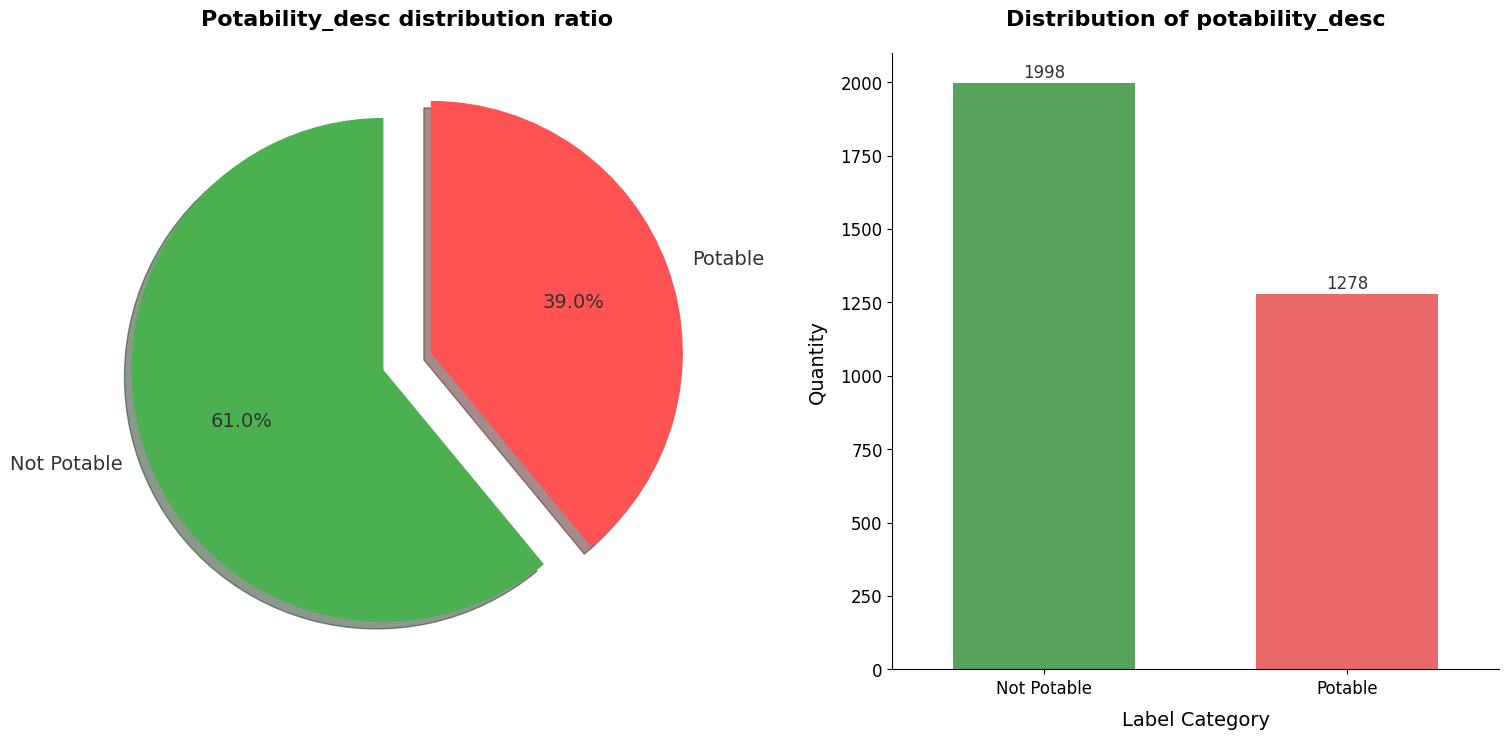

In [8]:
from utils import plot_label_distribution

plot_label_distribution(
    df=train, label_desc=LABEL_DESC,
    # pie_title=f'{LABEL_DESC} distribution ratio'.capitalize(),
    # bar_title=f'distribution of {LABEL_DESC}'.capitalize(),
)

In [9]:
from utils import plot_discrete_variable_label_relationship

# ================================
# ✅ 选择离散/类别特征（用于 EDA：离散特征 vs 标签）
# ================================
# TODO: 按需手动填写 1~5 个离散特征列名（来自 train.columns）
discrete_variables = [
    # "col_name_1",
    # "col_name_2",
]

# 留空将自动选择前 3 个类别特征
if len(discrete_variables) == 0:
    discrete_variables = [
        c for c in train.columns
        if c not in [LABEL, LABEL_DESC] and train[c].dtype == "object"
    ][:3]

for var in discrete_variables:
    plot_discrete_variable_label_relationship(
        df=train,
        var=var,
        label=LABEL,
        label_desc=LABEL_DESC,
    )


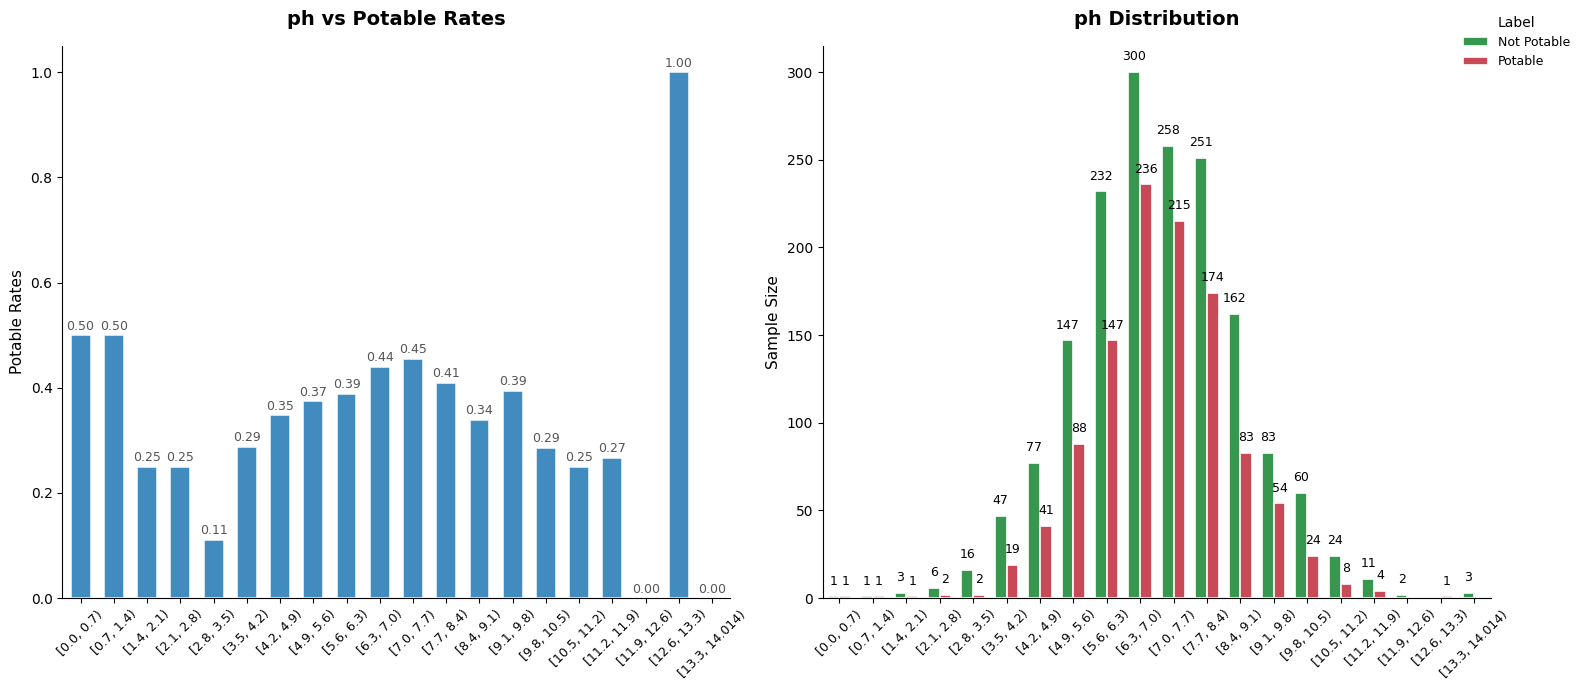

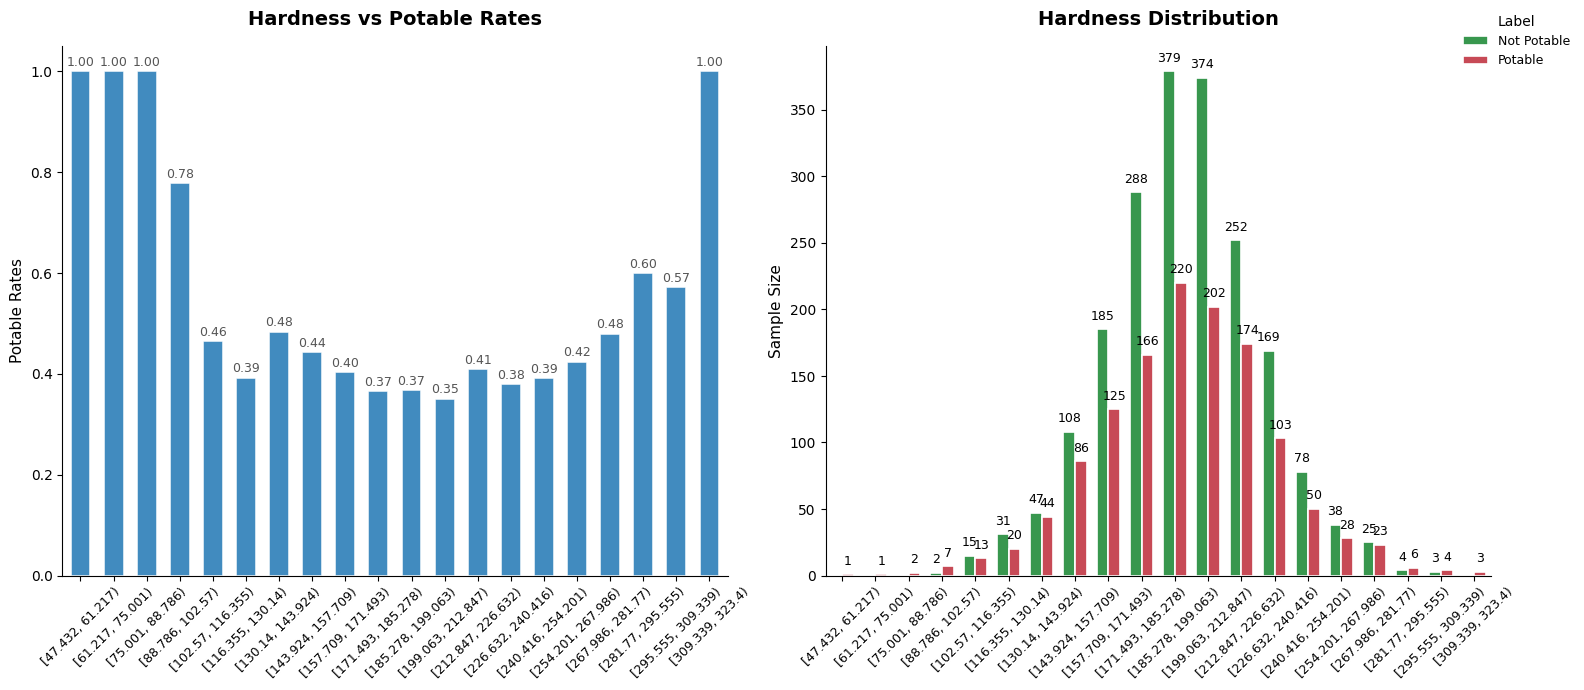

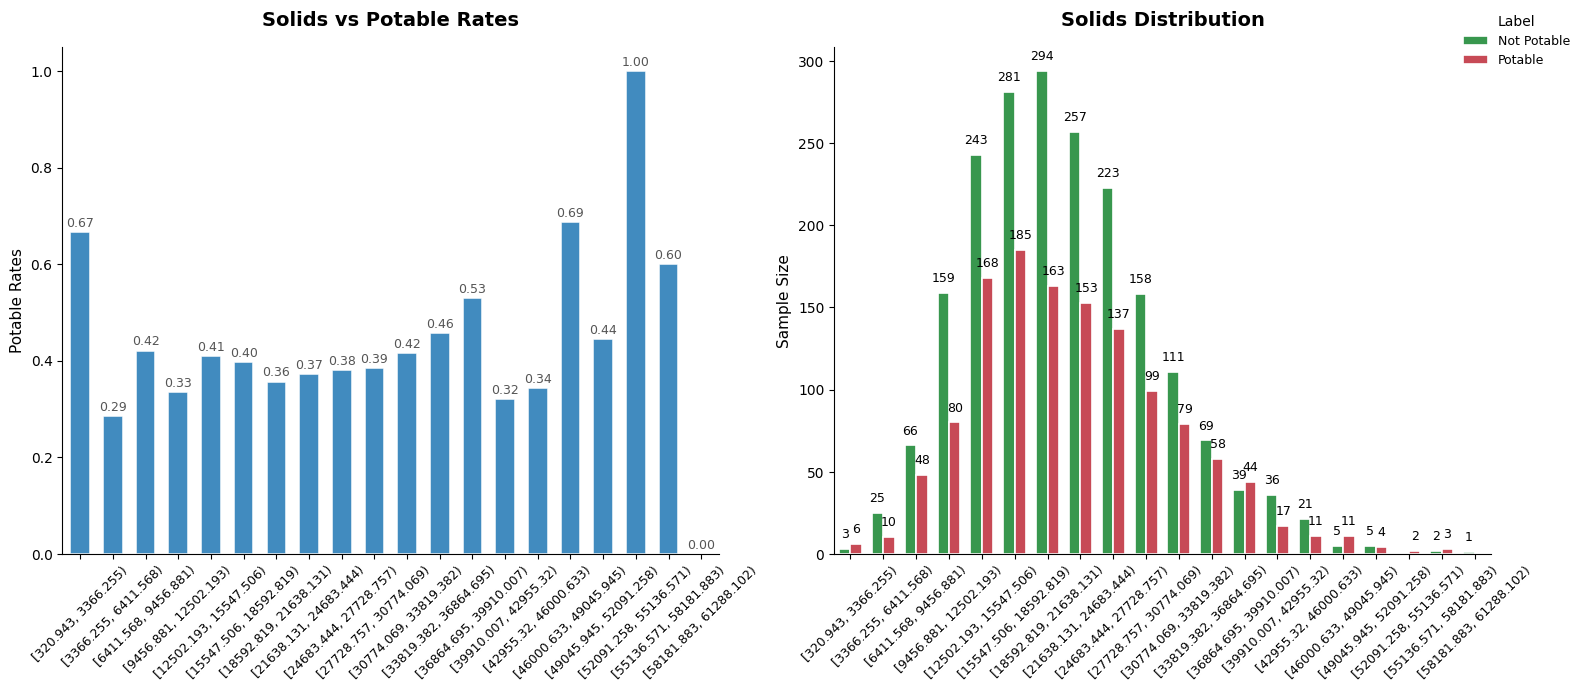

In [10]:
from utils import plot_continuous_variable_label_relationship

# ================================
# ✅ 选择连续/数值特征（用于 EDA：连续特征 vs 标签）
# ================================
# TODO: 按需手动填写 1~5 个连续特征列名（来自 train.columns）
continuous_variables = [
    # "num_col_1",
    # "num_col_2",
]

# 留空将自动选择前 3 个数值特征
if len(continuous_variables) == 0:
    continuous_variables = [
        c for c in train.columns
        if c not in [LABEL, LABEL_DESC] and pd.api.types.is_numeric_dtype(train[c])
    ][:3]

for var in continuous_variables:
    plot_continuous_variable_label_relationship(
        df=train,
        var=var,
        label=LABEL,
        label_desc=LABEL_DESC,
        bins=20,
        names=None,
    )


In [11]:
train.columns        # 查看全部列名

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability',
       'Potability_desc'],
      dtype='object')

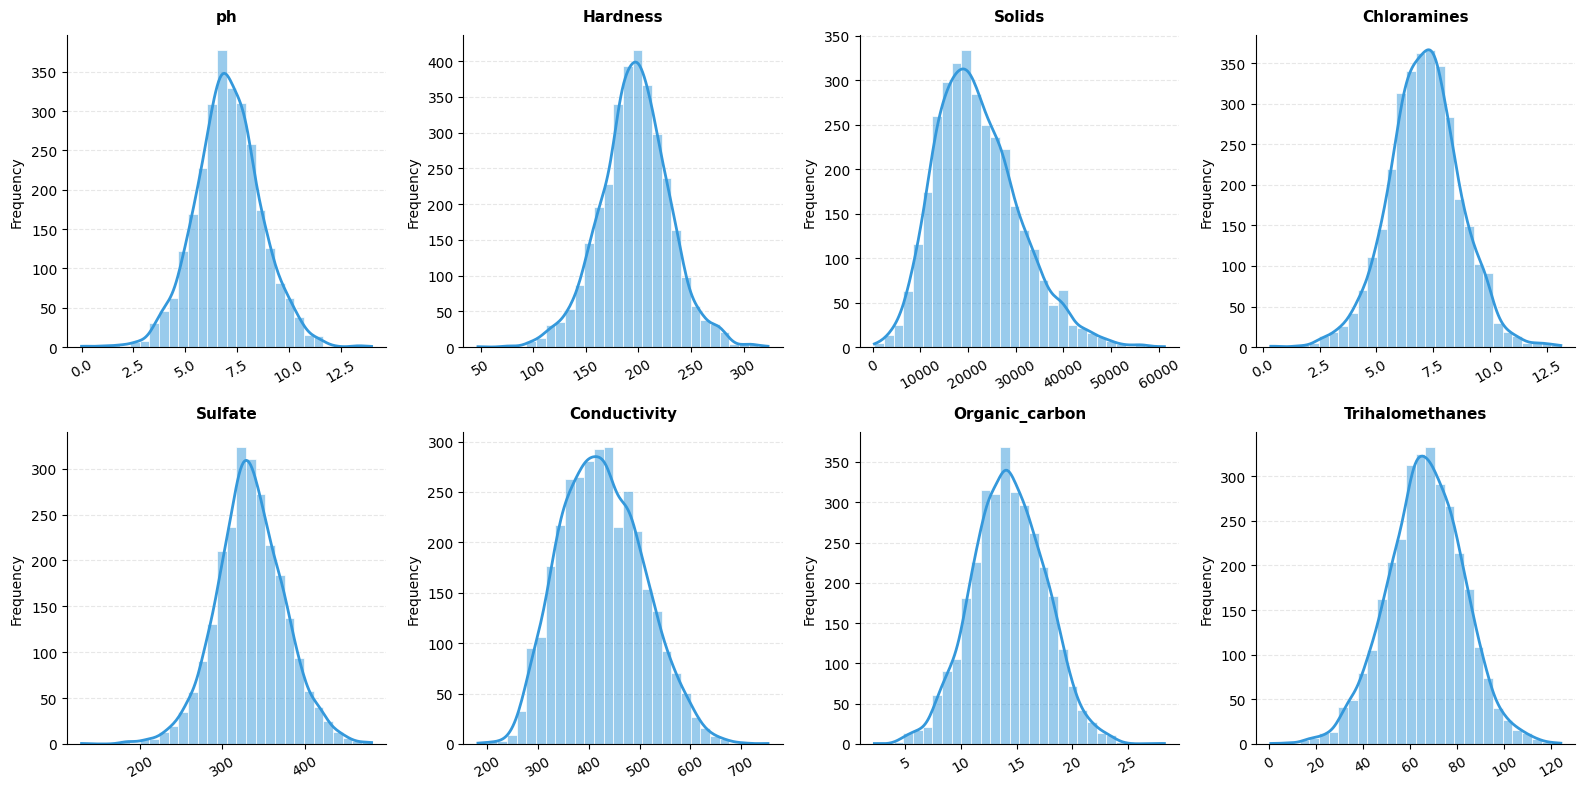

In [12]:
from utils import plot_variables_distribution

# ================================
# ✅ 数值特征分布可视化（建议选 10~20 个）
# ================================
# TODO: 手动指定你想重点展示的数值特征（来自 train.columns，注意排除 LABEL / LABEL_DESC）
NUM_FEATURE_NAMES = [
    # "num_col_1",
    # "num_col_2",
    'ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability',
       'Potability_desc'
]

# 若留空将自动选择前 16 个数值列（排除标签列）
if len(NUM_FEATURE_NAMES) == 0:
    NUM_FEATURE_NAMES = [
        c for c in train.columns
        if c not in [LABEL, LABEL_DESC] and pd.api.types.is_numeric_dtype(train[c])
    ][:16]

plot_variables_distribution(
    df=train,
    variables=NUM_FEATURE_NAMES,
)

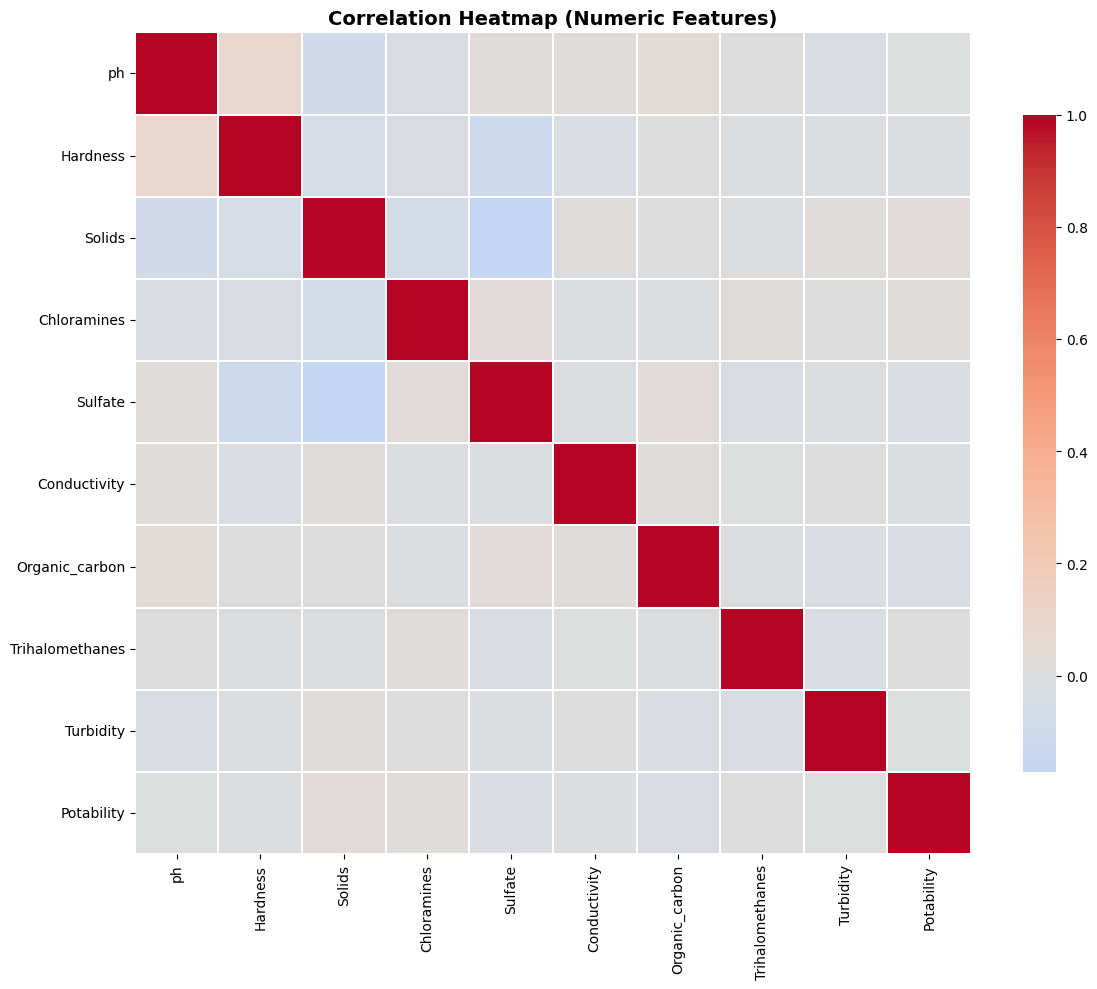

In [13]:
# ------------------------------------------------------------------
# Figure (Paper-like): Correlation Heatmap (Numeric Features)
# ------------------------------------------------------------------
from utils import plot_heatmap

plot_heatmap(train)
save_paper_figure('fig2_corr_heatmap.png', dpi=300, bbox_inches='tight')


# <a id='toc6_'></a>[数据预处理](#toc0_)


功能：处理数据中不规范列名与字符串，处理数据中的缺失值和异常值，同时记录异常/缺失标记，为建模做准备

In [14]:
import pandas as pd

# 设置显示的最大列数为 None（即不限制，显示所有列）
pd.set_option('display.max_columns', None)

print(f'train.head():')
print(train.head())

print(f'train.info():')
train.info()

print(f'train.describe(include=all):')
print(train.describe(include='all'))

print(f'train.isnull().sum().sort_values(ascending=False).head(30):')
print(train.isnull().sum().sort_values(ascending=False).head(30))

print(f'train.nunique().sort_values(ascending=False).head(30):')
print(train.nunique().sort_values(ascending=False).head(30))

print(f'train[num_cols].skew().sort_values(ascending=False).head(30)')
cat_cols = [c for c in train.columns if train[c].dtype == 'object']
num_cols = [c for c in train.columns if c not in cat_cols]
print(train[num_cols].skew().sort_values(ascending=False).head(30))


if test is None:
    print(f'Without test dataset')
else:
    print(f'test.head():')
    print(test.head())
    
    print(f'test.info():')
    test.info()


train.head():
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability Potability_desc  
0       10.379783        86.990970   2.963135           0     Not Potable  
1       15.180013        56.329076   4.500656           0     Not Potable  
2       16.868637        66.420093   3.055934           0     Not Potable  
3       18.436524       100.341674   4.628771           0     Not Potable  
4       11.558279        31.997993   4.075075           0     Not Potable  
train.info():
<class 'pandas.core.frame.DataFrame

# <a id='toc6_'></a>[数据预处理](#toc0_)

In [15]:
# ------------------------------------------------------------------
# 数据集预处理
# ------------------------------------------------------------------
import pandas as pd
import numpy as np
import re

class DataPreprocessing:
    """
    数据预处理类：负责异常值修正、缺失标记、类型转换及冗余列剔除。
    遵循 fit/transform 接口，确保训练与测试集逻辑一致。
    """
    def __init__(self):
        # 记录需要丢弃的列
        self.drop_cols = []
        # 记录数值型列的截断阈值 {col: (lower, upper)}
        self.clip_bounds = {}
        # 记录类似数值的字符串列（需转换类型）
        self.numeric_like_cols = []
        # 记录缺失率较高需要加标记位的列
        self.missing_flag_cols = []
        # 记录中位数与众数，用于轻量填充
        self.medians = {}
        self.modes = {}
        # 预设的缺失值标识符（统一转为 NaN）
        self.null_tokens = ['nan', 'na', 'n/a', 'null', 'none', '-', 'unknown', 'unk', '']

    def _is_id_column(self, s: pd.Series):
        """判断是否为 ID 类列"""
        # 模式匹配列名
        id_patterns = ['id', 'uuid', 'index', '序号', '编号', 'unnamed']
        if any(p in str(s.name).lower() for p in id_patterns):
            return True
        # 逻辑判断：object 类型且唯一值比例极高
        if s.dtype == 'object' and s.nunique() / len(s) > 0.98:
            return True
        return False

    def fit(self, X: pd.DataFrame):
        """学习训练集的统计量与特征分布"""
        # 复制数据避免修改原表
        X = X.copy()
        
        # 1. 识别需要丢弃的列
        temp_drop_cols = []
        for col in X.columns:
            # 全空列
            if X[col].isnull().all():
                temp_drop_cols.append(col)
                continue
            # 常量列
            if X[col].nunique() <= 1:
                temp_drop_cols.append(col)
                continue
            # ID 列
            if self._is_id_column(X[col]):
                temp_drop_cols.append(col)
                continue
        
        # 业务逻辑：识别并剔除可能的标签衍生列 (如 Potability_desc)
        # 如果列名包含 'desc' 且与 Potability 相关，则存入 drop_cols
        for col in X.columns:
            if 'desc' in col.lower() or 'target' in col.lower():
                temp_drop_cols.append(col)

        self.drop_cols = list(set(temp_drop_cols))
        
        # 2. 识别“伪装成字符串”的数值列 (如 '12.3%' 或 '1,000')
        object_cols = X.select_dtypes(include=['object']).columns
        for col in object_cols:
            if col in self.drop_cols: continue
            # 尝试转换：去空格、去百分号、去逗号
            converted = X[col].astype(str).str.replace(r'[%, ]', '', regex=True)
            converted = pd.to_numeric(converted, errors='coerce')
            # 如果转换成功率 > 90%，判定为数值列
            if converted.notnull().mean() >= 0.90:
                self.numeric_like_cols.append(col)
                X[col] = converted # 临时转换以便后续学分位数

        # 重新定义数值列（包含转换后的）
        num_cols = X.select_dtypes(include=[np.number]).columns
        num_cols = [c for c in num_cols if c not in self.drop_cols]

        # 3. 学习数值列的截断阈值与缺失标记位
        for col in num_cols:
            # 缺失标记：缺失率 >= 5% 时记录
            if X[col].isnull().mean() >= 0.05:
                self.missing_flag_cols.append(col)
            
            # 分位数截断阈值 (使用 0.5% 和 99.5% 避免极端异常值影响)
            low = X[col].quantile(0.005)
            high = X[col].quantile(0.995)
            
            # 业务约束：针对 pH 值特殊处理，确保在 [0, 14] 范围内
            if col.lower() == 'ph':
                low = max(0.0, low)
                high = min(14.0, high)
                
            self.clip_bounds[col] = (low, high)
            self.medians[col] = X[col].median()

        # 4. 学习类别列的众数
        cat_cols = X.select_dtypes(exclude=[np.number]).columns
        for col in cat_cols:
            if col in self.drop_cols: continue
            if not X[col].mode().empty:
                self.modes[col] = X[col].mode()[0]

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """应用预处理逻辑"""
        X = X.copy()

        # A. 基础清洗
        # 替换无穷大值为 NaN
        X.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # B. 字符串清洗与类型矫正
        for col in X.columns:
            if X[col].dtype == 'object':
                # 去空格
                X[col] = X[col].astype(str).str.strip()
                # 统一缺失标记
                mask = X[col].str.lower().isin(self.null_tokens)
                X.loc[mask, col] = np.nan
                
                # 数值转换逻辑 (百分号转为小数)
                if col in self.numeric_like_cols:
                    # 识别是否带百分号
                    has_pct = X[col].astype(str).str.contains('%').any()
                    X[col] = X[col].astype(str).str.replace(r'[%, ]', '', regex=True)
                    X[col] = pd.to_numeric(X[col], errors='coerce')
                    if has_pct:
                        X[col] = X[col] / 100.0

        # C. 缺失值标记位 (在填充前执行)
        for col in self.missing_flag_cols:
            if col in X.columns:
                X[f'{col}__isna'] = X[col].isna().astype('int8')

        # D. 数值列截断与异常标识
        num_cols = X.select_dtypes(include=[np.number]).columns
        for col in num_cols:
            if col in self.clip_bounds:
                low, high = self.clip_bounds[col]
                # 记录截断标记
                # X[f'{col}__clipped'] = ((X[col] < low) | (X[col] > high)).astype('int8')
                # 执行截断
                X[col] = X[col].clip(lower=low, upper=high)

        # E. 冗余列剔除
        X.drop(columns=[c for c in self.drop_cols if c in X.columns], errors='ignore', inplace=True)

        # F. 轻量级填充 (保障性措施)
        for col, val in self.medians.items():
            if col in X.columns:
                X[col] = X[col].fillna(val)
        for col, val in self.modes.items():
            if col in X.columns:
                X[col] = X[col].fillna(val)

        # G. 最终列名清理 (防止重复或特殊字符)
        # 确保列名唯一，如果重复则保留左侧
        X = X.loc[:, ~X.columns.duplicated()]
        
        return X




# <a id='toc7_'></a>[特征工程](#toc0_)

1. **通用编码与数值变换（可选）**  
   - 类别特征：有序编码 / One-Hot / 频数编码（更适合高基数类别）  
   - 数值特征：Log 变换 / 分箱 / 标准化前的截断（clip）

2. **交互与比例特征（可选）**  
   - 比例：A/B、A/(B+eps)、(A-B)、(A+B)  
   - 交互：A*B、A/B* C（按业务理解构建）

3. **缺失/异常信号显式化（推荐）**  
   - 缺失标记（isna）与异常标记（outlier flag）有时比“直接填充”更有信息量

4. **保持训练/测试一致性（强制）**  
   - 所有特征工程必须封装在 `FeatureGenerator.transform()` 中，并在训练与测试上同样执行

In [16]:
# ------------------------------------------------------------------
# 特征工程
# ------------------------------------------------------------------
import pandas as pd
import numpy as np
import re

class FeatureGenerator:
    """
    特征工程专家模块：专注于构造水质科学相关的物理/化学指标。
    修复说明：增加了对输入列存在性的校验，防止因预处理剔除列导致的 KeyError。
    """
    def __init__(self):
        self._is_fitted = False
        self.stats = {}
        # 预设业务分箱边界
        self.bin_edges = {
            'ph': [0, 6.5, 8.5, 14], 
            'Hardness': [0, 60, 120, 180, 500] 
        }

    def fit(self, X: pd.DataFrame):
        """学习训练集的全局统计量，增加列存在性判断"""
        # 学习 Solids 的分位数（如果列存在）
        if 'Solids' in X.columns:
            self.stats['Solids_q95'] = X['Solids'].quantile(0.95)
        
        # 学习 Turbidity 的均值（如果列存在）
        if 'Turbidity' in X.columns:
            self.stats['Turbidity_mean'] = X['Turbidity'].mean()
            
        self._is_fitted = True
        return self

    def _safe_object_values(self, df, obj_cols):
        """确保 object 列的取值仅包含安全字符"""
        for col in obj_cols:
            if col in df.columns:
                df[col] = df[col].fillna('MISSING').astype(str).apply(
                    lambda x: re.sub(r'[^A-Za-z0-9]+', '_', x).strip('_')
                )
                df.loc[df[col] == '', col] = 'EMPTY'
        return df

    def _sanitize_columns(self, df):
        """清理列名，确保只包含 A-Za-z0-9_ 且唯一"""
        new_cols = []
        for col in df.columns:
            clean_name = re.sub(r'[^A-Za-z0-9_]+', '_', str(col))
            new_cols.append(clean_name)
        
        final_cols = []
        seen = {}
        for col in new_cols:
            if col not in seen:
                final_cols.append(col)
                seen[col] = 1
            else:
                final_cols.append(f"{col}__dup{seen[col]}")
                seen[col] += 1
        df.columns = final_cols
        return df

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """执行特征构造"""
        if not self._is_fitted:
            self.fit(X)
        
        X = X.copy()
        X.replace([np.inf, -np.inf], np.nan, inplace=True)
        eps = 1e-6 

        # --- 1. 业务指标（仅在原始列存在时构造） ---
        
        # 溶解固体相关指标
        if 'Solids' in X.columns:
            if 'Conductivity' in X.columns:
                # 溶解固体与电导率比：反映水中离子组成的物理特性
                X['TDS_Conductivity_Ratio'] = X['Solids'] / (X['Conductivity'] + eps)
            if 'Sulfate' in X.columns:
                # 硫酸盐在总溶解固体中的占比
                X['Sulfate_Solids_Ratio'] = X['Sulfate'] / (X['Solids'] + eps)
            if 'Hardness' in X.columns:
                # 总硬度在总溶解固体中的占比
                X['Hardness_Solids_Ratio'] = X['Hardness'] / (X['Solids'] + eps)
            # 对数变换
            X['Log_Solids'] = np.log1p(X['Solids'])

        # pH相关指标
        if 'ph' in X.columns:
            # pH值偏离中性的程度
            X['PH_Neutral_Dev'] = (X['ph'] - 7.0).abs()
            # pH分箱
            X['PH_Level_Cat'] = np.digitize(X['ph'], self.bin_edges['ph']).astype(str)
            X['PH_Level_Cat'] = 'BIN_' + X['PH_Level_Cat']

        # 消毒剂与副产物指标
        if 'Organic_carbon' in X.columns:
            if 'Chloramines' in X.columns:
                # 有机碳与氯胺比：反映有机物可能消耗消毒剂的潜在强度
                X['OC_Chloramines_Ratio'] = X['Organic_carbon'] / (X['Chloramines'] + eps)
            if 'Trihalomethanes' in X.columns:
                # 三卤甲烷生成效率：单位有机碳产生的消毒副产物量
                X['THM_per_OC'] = X['Trihalomethanes'] / (X['Organic_carbon'] + eps)

        # 浊度波动指标
        if 'Turbidity' in X.columns and 'Turbidity_mean' in self.stats:
            X['Turbidity_Rel_Mean'] = X['Turbidity'] / (self.stats['Turbidity_mean'] + eps)

        # --- 2. 字段清理与合规化 ---
        
        # 自动识别 object 列（含新生成的 Cat 列）
        obj_cols = X.select_dtypes(include=['object']).columns
        X = self._safe_object_values(X, obj_cols)
        
        # 清理列名并去重
        X = self._sanitize_columns(X)
        
        return X



1. 从训练数据中分离目标变量（转为整数）和特征数据，复制测试数据。
2. 用训练特征拟合预处理模型，再分别对训练和测试特征做预处理。
3. 通过特征生成器对预处理后的训练、测试特征进行特征工程，确保处理一致性，为建模做准备。

In [17]:
from sklearn.model_selection import train_test_split

# ================================
# 训练/测试（或训练/验证）划分 + 预处理 + 特征工程
# ================================
# - 如果提供了外部 test.csv，则 test_X 来自外部测试集，test_y=None
# - 如果没有外部 test.csv，则自动从 train 中划分出 test_X/test_y（仅用于本地验证）
#
# 目标变量（确保在“标签处理”cell已经转换成 int 0/1）
train_y_full = train[LABEL].astype(int)

# 特征表（删除 LABEL 与 LABEL_DESC）
train_X_full = train.drop(columns=[LABEL, LABEL_DESC], errors='ignore')

if test is None:
    # 形式 B：只有一个数据表 -> 划分 hold-out
    train_X, test_X, train_y, test_y = train_test_split(
    train.drop(columns=[LABEL, LABEL_DESC]),  # drop LABEL LABEL_DESC
    train[LABEL],
    test_size=0.2, random_state=42,
)
else:
    # 形式 A：有外部测试集
    train_X, train_y = train_X_full, train_y_full
    test_X, test_y = test.copy(), None

# 初始化数据预处理类实例
preprocessor = DataPreprocessing()

# 用训练数据拟合预处理模型（学习训练数据中的统计特性，如缺失值填充策略等）
preprocessor.fit(train_X)

# 对训练特征数据应用预处理（使用拟合好的参数对训练数据进行转换）
train_proc = preprocessor.transform(train_X)

# 对测试特征数据应用同样的预处理（保证训练集和测试集处理方式一致）
test_proc  = preprocessor.transform(test_X)

# 初始化特征生成器实例（即前面定义的FeatureGenerator类，用于生成高级特征）
feat_gen = FeatureGenerator()

# 对预处理后的训练数据进行特征工程（生成衍生特征，如比例特征、交互特征等）
train_fe = feat_gen.transform(train_proc)

# 对预处理后的测试数据进行同样的特征工程（保持特征一致性）
test_fe  = feat_gen.transform(test_proc)


1. 精准划分特征类型
2. 为不同特征类型构建专属处理管道
3. 整合列转换器与应用完整处理流程

In [18]:
def clean_feature_names(columns):
    new_columns = []
    for col in columns:
        # 1. 替换特殊字符 (括号, &, %, 逗号) 为下划线
        new_col = re.sub(r'[(),&%\s:-]+', '_', col)
        # 2. 去除首尾可能的下划线
        new_col = new_col.strip('_')
        new_columns.append(new_col)

    return new_columns

In [19]:
from utils import construct_process_pipeline

# 划分类别型特征列：筛选数据类型为object的列（通常为字符串类型的类别特征）
cat_cols = [c for c in train_fe.columns if train_fe[c].dtype == 'object']

# 划分数值型特征列：除类别特征外的其他列（通常为int/float类型的连续或离散数值特征）
num_cols = [c for c in train_fe.columns if c not in cat_cols]

# 构建预处理流程管道
preprocess = construct_process_pipeline(num_cols, cat_cols)

# 用训练集拟合完整的预处理流程（学习数值特征的中位数、类别特征的众数和编码规则等）
# 并对训练特征数据进行最终转换，得到可直接输入模型的特征矩阵
X_train = preprocess.fit_transform(train_fe)
columns = clean_feature_names(preprocess.get_feature_names_out())  # 处理特征名称中的违规符号
X_train = pd.DataFrame(X_train, columns=columns)

# 用拟合好的预处理流程转换测试特征数据（保证与训练集处理逻辑完全一致）
X_test = preprocess.transform(test_fe)
X_test = pd.DataFrame(X_test, columns=columns)

In [20]:
X_train.head()

,ph,Hardness,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,ph__isna,Sulfate__isna,PH_Neutral_Dev,OC_Chloramines_Ratio,THM_per_OC,PH_Level_Cat_BIN_1,PH_Level_Cat_BIN_2,PH_Level_Cat_BIN_3
0,6.623614,203.030141,6.049601,311.726288,410.243247,15.914500,65.021229,0.0,0.0,0.376386,2.630669,4.085659,0.0,1.0,0.0
1,6.684700,193.840931,9.876574,344.535407,498.063996,8.818757,66.659352,0.0,0.0,0.315300,0.892896,7.558814,0.0,1.0,0.0
2,6.836060,205.667718,6.712854,297.837188,494.484249,13.808923,70.714225,0.0,0.0,0.163940,2.057086,5.120908,0.0,1.0,0.0
3,7.021617,183.488839,9.777807,319.870584,482.445026,13.309723,46.853410,1.0,0.0,0.021617,1.361217,3.520239,0.0,1.0,0.0
4,6.406798,182.885137,7.462758,332.486731,398.779746,17.301617,64.070236,0.0,0.0,0.593202,2.318394,3.703136,1.0,0.0,0.0


# <a id='toc8_'></a>[贝叶斯优化参数空间](#toc0_)

In [21]:
# ------------------------------------------------------------------
# 小样本快速优化（用 3 折 & 700 样本）
# ------------------------------------------------------------------
train_size = 800 if X_train.shape[0] > 800 else int(X_train.shape[0] * 0.8)
sample_idx, _ = train_test_split(
    np.arange(X_train.shape[0]), stratify=train_y, train_size=train_size, random_state=42
)
X_sample, y_sample = X_train.iloc[sample_idx], train_y.iloc[sample_idx]

class_weight = len(train_y) / (2 * np.bincount(train_y))  # 类别权重
xgb_scale_weight = class_weight[1] / class_weight[0] if 'class_weight' in locals() else 1.0

from utils import (
    bayes_opt_serial, bayes_opt, TunedMLP,
    lr_space, svc_space, dt_space, rf_space,
    gbdt_space, nb_space, mlp_space,
    lgb_space, xgb_space, cat_space,
)

# ================= 基础模型 (Sklearn) =================
print('【逻辑回归 (LR) 贝叶斯优化】')
model = LogisticRegression(max_iter=2000, random_state=42, n_jobs=-1)
lr_model, lr_best = bayes_opt(model, lr_space, X_sample, y_sample, n_iter=12)

print('【支持向量机 (SVM) 贝叶斯优化】')
# SVM 训练较慢，probability=True 会更慢，但在小样本(800)下可接受
model = SVC(probability=False, class_weight='balanced', random_state=42)
svm_model, svm_best = bayes_opt(model, svc_space, X_sample, y_sample, n_iter=1)

print('【决策树 (DT) 贝叶斯优化】')
model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model, dt_best = bayes_opt(model, dt_space, X_sample, y_sample, n_iter=12)

print('【随机森林 (RF) 贝叶斯优化】')
model = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
rf_model, rf_best = bayes_opt(model, rf_space, X_sample, y_sample, n_iter=12)

print('【GBDT (Sklearn) 贝叶斯优化】')
# Sklearn GBDT 原生不支持 class_weight 参数，通常需手动处理样本权重或忽略
model = GradientBoostingClassifier(random_state=42)
gbdt_model, gbdt_best = bayes_opt(model, gbdt_space, X_sample, y_sample, n_iter=12)

print('【朴素贝叶斯 (NB) 贝叶斯优化】')
model =  GaussianNB()
nb_model, nb_best = bayes_opt(model, nb_space, X_sample, y_sample, n_iter=12)

print('【MLP (神经网络) 贝叶斯优化】')
model = TunedMLP(max_iter=1000, early_stopping=True, random_state=42)
mlp_model, mlp_best = bayes_opt_serial(model, mlp_space, X_sample, y_sample, n_iter=12)
mlp_best = dict(mlp_best)
best_idx = int(mlp_best.pop('layer_idx')) # 移除 layer_idx
mlp_best['hidden_layer_sizes'] = [(50,), (100,), (50, 50)][best_idx] # 加回 hidden_layer_sizes

# ================= 提升树模型 (Boosting) =================
print('【LightGBM 贝叶斯优化】')
model = lgb.LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1)
lgb_model, lgb_best = bayes_opt(model, lgb_space, X_sample, y_sample, cv=3, n_iter=12)

print('【XGBoost 贝叶斯优化】')
model = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='logloss', tree_method='hist',
    n_jobs=-1, scale_pos_weight=xgb_scale_weight, random_state=42,
)
xgb_model, xgb_best = bayes_opt(model, xgb_space, X_sample, y_sample, cv=3, n_iter=12)

print('【CatBoost 贝叶斯优化】')
model = cb.CatBoostClassifier(
    loss_function='Logloss', eval_metric='F1', thread_count=-1,
    auto_class_weights='Balanced', random_state=42, verbose=False,
)
cat_model, cat_best = bayes_opt(model, cat_space, X_sample, y_sample, cv=3, n_iter=1)

【逻辑回归 (LR) 贝叶斯优化】


/root/miniconda3/envs/test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/root/miniconda3/envs/test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/root/miniconda3/envs/test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(
/root/miniconda3/envs/test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Ple

【支持向量机 (SVM) 贝叶斯优化】
【决策树 (DT) 贝叶斯优化】
【随机森林 (RF) 贝叶斯优化】
【GBDT (Sklearn) 贝叶斯优化】
【朴素贝叶斯 (NB) 贝叶斯优化】
【MLP (神经网络) 贝叶斯优化】
【LightGBM 贝叶斯优化】
【XGBoost 贝叶斯优化】
【CatBoost 贝叶斯优化】


# <a id='toc9_'></a>[合成数据生成](#toc0_)
功能：通过smote插值法为少数类生成合成样本，缓解数据不平衡问题

In [22]:
from utils import apply_sampling

# 设置采样策略，可选值：none / smote / undersample / combined / knn
SAMPLING_STRATEGY = 'smote'
# 打印当前使用的采样策略
print(f'>>> 数据采样策略：{SAMPLING_STRATEGY}')

>>> 数据采样策略：smote


# <a id='toc10_'></a>[5 折交叉验证训练](#toc0_)

In [23]:
from utils import f1_best_threshold, get_best_f1

# 1.1 基础模型 (Sklearn)
oof_lr, pred_lr = np.zeros(X_train.shape[0]), np.zeros(X_test.shape[0])
oof_svm, pred_svm = np.zeros(X_train.shape[0]), np.zeros(X_test.shape[0])
oof_dt, pred_dt = np.zeros(X_train.shape[0]), np.zeros(X_test.shape[0])
oof_rf, pred_rf = np.zeros(X_train.shape[0]), np.zeros(X_test.shape[0])
oof_gbdt, pred_gbdt = np.zeros(X_train.shape[0]), np.zeros(X_test.shape[0])
oof_nb, pred_nb = np.zeros(X_train.shape[0]), np.zeros(X_test.shape[0])
oof_mlp, pred_mlp = np.zeros(X_train.shape[0]), np.zeros(X_test.shape[0])

# 1.2 提升树模型 (Boosting)
oof_lgb, pred_lgb = np.zeros(X_train.shape[0]), np.zeros(X_test.shape[0])
oof_xgb, pred_xgb = np.zeros(X_train.shape[0]), np.zeros(X_test.shape[0])
oof_cat, pred_cat = np.zeros(X_train.shape[0]), np.zeros(X_test.shape[0])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (trn, val) in enumerate(skf.split(X_train, train_y), 1):
    print(f'=== Fold {fold} ===')
    X_resample, X_val = X_train.iloc[trn], X_train.iloc[val]
    y_resample, y_val = train_y.iloc[trn], train_y.iloc[val]

    # 采样仅对训练集
    X_trn, y_trn = apply_sampling(X_resample, y_resample, strategy=SAMPLING_STRATEGY)

    # ------------------------------------------------------
    # A组：Sklearn 类模型 (标准 .fit 接口)
    # ------------------------------------------------------
    # 1. Logistic Regression
    m_lr = LogisticRegression(**lr_best, class_weight='balanced', max_iter=2000, random_state=42, n_jobs=-1)
    m_lr.fit(X_trn, y_trn)
    oof_lr[val] = m_lr.predict_proba(X_val)[:, 1]
    pred_lr += m_lr.predict_proba(X_test)[:, 1] / skf.n_splits

    # 2. SVM (注意: probability=True 必须开启，速度较慢)
    m_svm = SVC(**svm_best, probability=True, class_weight='balanced', random_state=42)
    m_svm.fit(X_trn, y_trn)
    oof_svm[val] = m_svm.predict_proba(X_val)[:, 1]
    pred_svm += m_svm.predict_proba(X_test)[:, 1] / skf.n_splits

    # 3. Decision Tree
    m_dt = DecisionTreeClassifier(**dt_best, class_weight='balanced', random_state=42)
    m_dt.fit(X_trn, y_trn)
    oof_dt[val] = m_dt.predict_proba(X_val)[:, 1]
    pred_dt += m_dt.predict_proba(X_test)[:, 1] / skf.n_splits

    # 4. Random Forest
    m_rf = RandomForestClassifier(**rf_best, class_weight='balanced', n_jobs=-1, random_state=42)
    m_rf.fit(X_trn, y_trn)
    oof_rf[val] = m_rf.predict_proba(X_val)[:, 1]
    pred_rf += m_rf.predict_proba(X_test)[:, 1] / skf.n_splits

    # 5. GBDT (Sklearn原生) - 不支持 class_weight
    m_gbdt = GradientBoostingClassifier(**gbdt_best, random_state=42)
    m_gbdt.fit(X_trn, y_trn)
    oof_gbdt[val] = m_gbdt.predict_proba(X_val)[:, 1]
    pred_gbdt += m_gbdt.predict_proba(X_test)[:, 1] / skf.n_splits

    # 6. Naive Bayes - 不支持 class_weight
    m_nb = GaussianNB(**nb_best)    
    m_nb.fit(X_trn, y_trn)
    oof_nb[val] = m_nb.predict_proba(X_val)[:, 1]
    pred_nb += m_nb.predict_proba(X_test)[:, 1] / skf.n_splits

    # 7. MLP - 不直接支持 class_weight
    m_mlp = MLPClassifier(**mlp_best, max_iter=1000, random_state=42)
    m_mlp.fit(X_trn, y_trn)
    oof_mlp[val] = m_mlp.predict_proba(X_val)[:, 1]
    pred_mlp += m_mlp.predict_proba(X_test)[:, 1] / skf.n_splits

    # ------------------------------------------------------
    # B组：Boosting 类模型 (支持 eval_set 早停)
    # ------------------------------------------------------
    # 8. LightGBM
    m_lgb = lgb.LGBMClassifier(**lgb_best, class_weight='balanced', n_jobs=-1, verbose=-1)
    m_lgb.fit(X_trn, y_trn, eval_set=[(X_val, y_val)]) # callbacks=[lgb.early_stopping(50)] 可选
    oof_lgb[val] = m_lgb.predict_proba(X_val)[:, 1]
    pred_lgb += m_lgb.predict_proba(X_test)[:, 1] / skf.n_splits

    # 9. XGBoost
    neg, pos = np.bincount(y_trn)
    spw = neg / pos
    m_xgb = xgb.XGBClassifier(
        **xgb_best, tree_method='hist', n_jobs=-1,
        scale_pos_weight=spw, early_stopping_rounds=50
    )
    m_xgb.fit(X_trn, y_trn, eval_set=[(X_val, y_val)], verbose=0)
    oof_xgb[val] = m_xgb.predict_proba(X_val)[:, 1]
    pred_xgb += m_xgb.predict_proba(X_test)[:, 1] / skf.n_splits

    # 10. CatBoost
    m_cat = cb.CatBoostClassifier(
        **cat_best, thread_count=-1, verbose=False,
        auto_class_weights='Balanced', early_stopping_rounds=50
    )
    m_cat.fit(X_trn, y_trn, eval_set=(X_val, y_val))
    oof_cat[val] = m_cat.predict_proba(X_val)[:, 1]
    pred_cat += m_cat.predict_proba(X_test)[:, 1] / skf.n_splits

    print(f"   [Sklearn] LR:{get_best_f1(y_val, oof_lr[val]):.3f} | SVM:{get_best_f1(y_val, oof_svm[val]):.3f} | DT:{get_best_f1(y_val, oof_dt[val]):.3f} | RF:{get_best_f1(y_val, oof_rf[val]):.3f}")
    print(f"   [Others]  GBDT:{get_best_f1(y_val, oof_gbdt[val]):.3f} | NB:{get_best_f1(y_val, oof_nb[val]):.3f} | MLP:{get_best_f1(y_val, oof_mlp[val]):.3f}")
    print(f"   [Boosting] LGB:{get_best_f1(y_val, oof_lgb[val]):.3f} | XGB:{get_best_f1(y_val, oof_xgb[val]):.3f} | CAT:{get_best_f1(y_val, oof_cat[val]):.3f}")
    print("-" * 50)

=== Fold 1 ===


/root/miniconda3/envs/test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   [Sklearn] LR:0.567 | SVM:0.564 | DT:0.567 | RF:0.581
   [Others]  GBDT:0.597 | NB:0.571 | MLP:0.564
   [Boosting] LGB:0.603 | XGB:0.589 | CAT:0.602
--------------------------------------------------
=== Fold 2 ===


/root/miniconda3/envs/test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   [Sklearn] LR:0.570 | SVM:0.566 | DT:0.573 | RF:0.586
   [Others]  GBDT:0.577 | NB:0.574 | MLP:0.574
   [Boosting] LGB:0.581 | XGB:0.587 | CAT:0.600
--------------------------------------------------
=== Fold 3 ===


/root/miniconda3/envs/test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   [Sklearn] LR:0.569 | SVM:0.566 | DT:0.572 | RF:0.579
   [Others]  GBDT:0.590 | NB:0.570 | MLP:0.576
   [Boosting] LGB:0.604 | XGB:0.605 | CAT:0.605
--------------------------------------------------
=== Fold 4 ===
   [Sklearn] LR:0.576 | SVM:0.566 | DT:0.583 | RF:0.595
   [Others]  GBDT:0.592 | NB:0.580 | MLP:0.567
   [Boosting] LGB:0.586 | XGB:0.591 | CAT:0.598
--------------------------------------------------
=== Fold 5 ===


/root/miniconda3/envs/test/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


   [Sklearn] LR:0.580 | SVM:0.566 | DT:0.571 | RF:0.616
   [Others]  GBDT:0.604 | NB:0.581 | MLP:0.571
   [Boosting] LGB:0.614 | XGB:0.612 | CAT:0.630
--------------------------------------------------


# <a id='toc11_'></a>[最优模型选择（无模型融合）](#toc0_)


## <a id='toc11_1_'></a>[基于 OOF F1 的最优单模型选择](#toc0_)


In [24]:
# ======================================================
# 无模型融合版本：直接选择最优单模型（按 OOF 最佳 F1）
# ======================================================

# 1. 整理所有模型的 OOF 和 Test 预测值
# 格式: (短名, OOF数组, Test概率数组)
model_list = [
    ('LR',   oof_lr,   pred_lr),
    ('SVM',  oof_svm,  pred_svm),
    ('DT',   oof_dt,   pred_dt),
    ('RF',   oof_rf,   pred_rf),
    ('GBDT', oof_gbdt, pred_gbdt),
    ('NB',   oof_nb,   pred_nb),
    ('MLP',  oof_mlp,  pred_mlp),
    ('LGB',  oof_lgb,  pred_lgb),
    ('XGB',  oof_xgb,  pred_xgb),
    ('CAT',  oof_cat,  pred_cat)
]

# 2. 选择最佳单模型（基于 OOF 的最佳 F1）
name_map = {
    'LR': 'Logistic Regression',
    'SVM': 'SVM',
    'DT': 'Decision Tree',
    'RF': 'Random Forest',
    'GBDT': 'GBDT',
    'NB': 'Naive Bayes',
    'MLP': 'MLP',
    'LGB': 'LightGBM',
    'XGB': 'XGBoost',
    'CAT': 'CatBoost'
}

best_short = None
best_model_name = None
best_model_oof = None
best_model_test = None
best_thr = None
best_f1 = -1

print("=== 单模型 OOF 最佳 F1 表现 ===")
for short, oof, pred in model_list:
    # f1_best_threshold 返回 (threshold, f1_score)
    thr, f1 = f1_best_threshold(train_y, oof)
    print(f"{short:4s} | F1={f1:.4f} @ thr={thr:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr
        best_short = short
        best_model_name = name_map.get(short, short)
        best_model_oof = oof
        best_model_test = pred

print(f"\n>>> 最佳单模型（无融合）: 【{best_model_name}】({best_short})")
print(f">>> OOF 最佳 F1 : {best_f1:.4f}")
print(f">>> OOF 最佳阈值: {best_thr:.4f}")

# 3. 最终用于提交的 Test 概率（直接使用最佳单模型）
final_prob_test = best_model_test

=== 单模型 OOF 最佳 F1 表现 ===
LR   | F1=0.5670 @ thr=0.3116
SVM  | F1=0.5660 @ thr=0.5000
DT   | F1=0.5717 @ thr=0.0769
RF   | F1=0.5831 @ thr=0.3374
GBDT | F1=0.5859 @ thr=0.0837
NB   | F1=0.5692 @ thr=0.1072
MLP  | F1=0.5660 @ thr=0.0074
LGB  | F1=0.5905 @ thr=0.3018
XGB  | F1=0.5910 @ thr=0.3133
CAT  | F1=0.5980 @ thr=0.3629

>>> 最佳单模型（无融合）: 【CatBoost】(CAT)
>>> OOF 最佳 F1 : 0.5980
>>> OOF 最佳阈值: 0.3629


In [25]:
# ------------------------------------------------------------------
# Table (Paper-like): Model Performance Summary (OOF)
# ------------------------------------------------------------------
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# 说明：这里使用 OOF 概率 + best_thr（最佳单模型阈值）做二值化，计算 Accuracy/F1；AUC 直接用概率
rows = []
for name, oof, _ in model_list:
    # 默认用全局 best_thr；如果你更想每个模型都用各自最优阈值，可改为 f1_best_threshold(y, oof)
    y_pred = (oof >= best_thr).astype(int)
    rows.append({
        'Model': name,
        'Accuracy(thr=best_thr)': accuracy_score(train_y, y_pred),
        'F1(thr=best_thr)': f1_score(train_y, y_pred),
        'ROC_AUC': roc_auc_score(train_y, oof),
    })

metrics_df = pd.DataFrame(rows).sort_values('ROC_AUC', ascending=False)
display(metrics_df)
save_exp_csv(metrics_df, 'model_performance_oof.csv', index=False)

,Model,Accuracy(thr=best_thr),F1(thr=best_thr),ROC_AUC
9,CAT,0.572519,0.597990,0.675695
8,XGB,0.560687,0.584326,0.653599
7,LGB,0.569084,0.578259,0.650225
3,RF,0.516412,0.580880,0.644818
4,GBDT,0.594275,0.526081,0.636870
2,DT,0.539313,0.537371,0.597447
5,NB,0.467557,0.545751,0.572198
0,LR,0.408779,0.565010,0.543665
6,MLP,0.404962,0.562202,0.536506
1,SVM,0.394656,0.565955,0.500000


>>> 已保存: exp_figs/model_performance_oof.csv


In [26]:
# ------------------------------------------------------------------
# Export: Model Metrics Table (Paper-like Table II) + Simple Bars
# ------------------------------------------------------------------
import os
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

rows = []
# 复用前面 model_list: (name, oof, pred)
for name, oof, _ in model_list:
    # 默认阈值 0.5 的 accuracy/f1（也可以用 best_thr，但为可比性这里统一 0.5）
    y_pred = (oof >= 0.5).astype(int)
    rows.append({
        'Model': name,
        'ROC_AUC': roc_auc_score(train_y, oof),
        'Accuracy@0.5': accuracy_score(train_y, y_pred),
        'F1@0.5': f1_score(train_y, y_pred)
    })

# 加入最佳单模型（无融合）
rows.append({
    'Model': f'Best({best_short})',
    'ROC_AUC': roc_auc_score(train_y, best_model_oof),
    'Accuracy@0.5': accuracy_score(train_y, (best_model_oof >= 0.5).astype(int)),
    'F1@0.5': f1_score(train_y, (best_model_oof >= 0.5).astype(int))
})
df_metrics = pd.DataFrame(rows).sort_values('ROC_AUC', ascending=False)
save_exp_csv(df_metrics, 'table2_model_metrics.csv', index=False)
save_paper_csv(df_metrics, 'table2_model_metrics.csv', index=False)

>>> 已保存: exp_figs/table2_model_metrics.csv


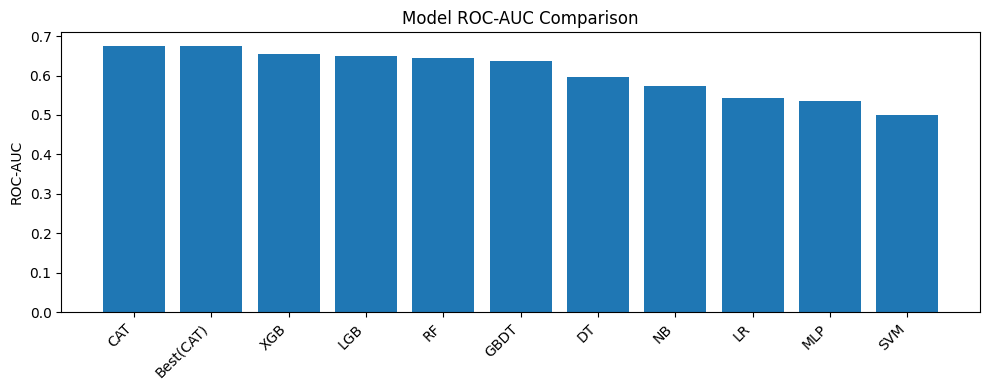

In [27]:
# 简单柱状图：ROC-AUC
plt.figure(figsize=(10, 4))
plt.bar(df_metrics['Model'], df_metrics['ROC_AUC'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('ROC-AUC')
plt.title('Model ROC-AUC Comparison')
plt.tight_layout()
save_exp_figure('model_auc_bar.png')
plt.show()
plt.close()

## <a id='toc11_2_'></a>[（已移除）Stacking/融合](#toc0_)

本版本已去除加权融合与 Stacking，仅保留“最优单模型选择”。


In [28]:
# Stacking / 融合已移除：本版本不再训练元模型。

# <a id='toc12_'></a>[提交文件](#toc0_)



In [29]:
# ================================
# 提交文件（可选）
# ================================
# 说明：
# - 若你提供了 SAMPLE_SUB_PATH，则 sub != None，会在这里写出 submission
# - 若没有 sample_submission，本 cell 会自动跳过
if sub is not None:
    sub[LABEL] = (final_prob_test >= best_thr).astype(int)
    sub.to_csv(SUBMISSION_OUT, index=False)
    print(f'>>> 提交文件已保存：{SUBMISSION_OUT}')
else:
    print(">>> 未提供 SAMPLE_SUB_PATH，跳过提交文件生成。")


>>> 未提供 SAMPLE_SUB_PATH，跳过提交文件生成。


# <a id='toc13_'></a>[结果可视化](#toc0_)

正在绘制 ROC/PR 曲线...


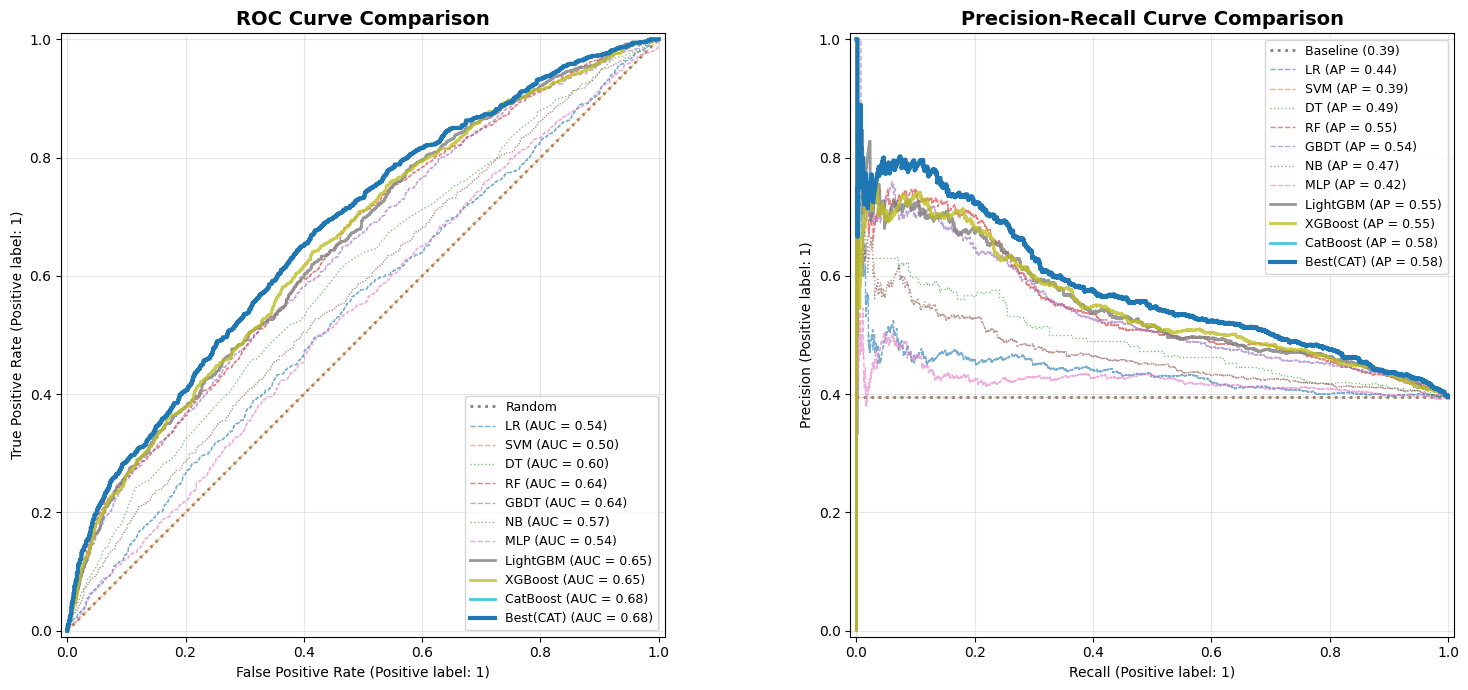

In [30]:
from utils import plot_roc_pr_curve

plot_data = [
    # --- 基础模型 (Sklearn) ---
    (oof_lr,   'LR',   {'lw': 1, 'alpha': 0.6, 'linestyle': '--'}),
    (oof_svm,  'SVM',  {'lw': 1, 'alpha': 0.6, 'linestyle': '--'}),
    (oof_dt,   'DT',   {'lw': 1, 'alpha': 0.6, 'linestyle': ':'}),
    (oof_rf,   'RF',   {'lw': 1, 'alpha': 0.6, 'linestyle': '--'}),
    (oof_gbdt, 'GBDT', {'lw': 1, 'alpha': 0.6, 'linestyle': '--'}),
    (oof_nb,   'NB',   {'lw': 1, 'alpha': 0.6, 'linestyle': ':'}),
    (oof_mlp,  'MLP',  {'lw': 1, 'alpha': 0.6, 'linestyle': '--'}),
    
    # --- 提升树模型 (Boosting) ---
    (oof_lgb,  'LightGBM', {'lw': 2, 'alpha': 0.8}),
    (oof_xgb,  'XGBoost',  {'lw': 2, 'alpha': 0.8}),
    (oof_cat,  'CatBoost', {'lw': 2, 'alpha': 0.8}),

    # --- 最佳单模型（无融合） ---
    (best_model_oof, f'Best({best_short})', {'lw': 3, 'alpha': 1.0, 'zorder': 10}),
    
    # --- 融合模型 (Ensemble) ---
]
plot_roc_pr_curve(train_y, plot_data)
save_paper_figure('roc_pr_all_models.png')

正在筛选最佳单模型...

>>> 最佳模型: 【CatBoost】
>>> 最佳 F1 : 0.5980
>>> 最佳阈值: 0.3629


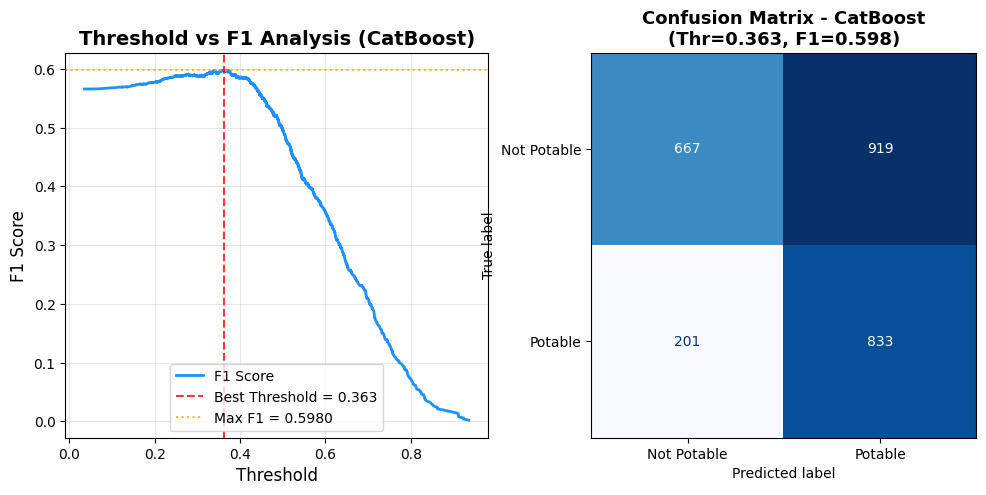

In [31]:
from utils import plot_best_model_analysis

# ======================================================
# 1. 筛选最好单模
# ======================================================
candidates = {
    'Logistic Regression': oof_lr,
    'SVM': oof_svm,
    'Decision Tree': oof_dt,
    'Random Forest': oof_rf,
    'GBDT': oof_gbdt,
    'Naive Bayes': oof_nb,
    'MLP': oof_mlp,
    'LightGBM': oof_lgb,
    'XGBoost': oof_xgb,
    'CatBoost': oof_cat
}

best_model_name = None
best_model_oof = None
global_best_f1 = -1
global_best_thr = -1

print("正在筛选最佳单模型...")
for name, oof_pred in candidates.items():
    # 计算该模型下的最佳阈值和F1
    p, r, t = precision_recall_curve(train_y, oof_pred)
    f1_scores = 2 * (p * r) / (p + r + 1e-8)

    idx = np.argmax(f1_scores)
    current_max_f1 = f1_scores[idx]
    
    current_best_thr = t[idx] if idx < len(t) else t[-1]
    
    if current_max_f1 > global_best_f1:
        global_best_f1 = current_max_f1
        global_best_thr = current_best_thr
        best_model_name = name
        best_model_oof = oof_pred

print(f"\n>>> 最佳模型: 【{best_model_name}】")
print(f">>> 最佳 F1 : {global_best_f1:.4f}")
print(f">>> 最佳阈值: {global_best_thr:.4f}")

# ======================================================
# 绘制最佳单模型的 阈值-F1 曲线 和 混淆矩阵
# ======================================================
plot_best_model_analysis(
    train_y, best_model_name, best_model_oof, global_best_f1, global_best_thr,
    display_labels=list(label_map_int2str.values()),
)
save_exp_figure(f'threshold_f1_confusion_matrix_{best_model_name.replace(" ", "_")}')
plt.show()
plt.close()


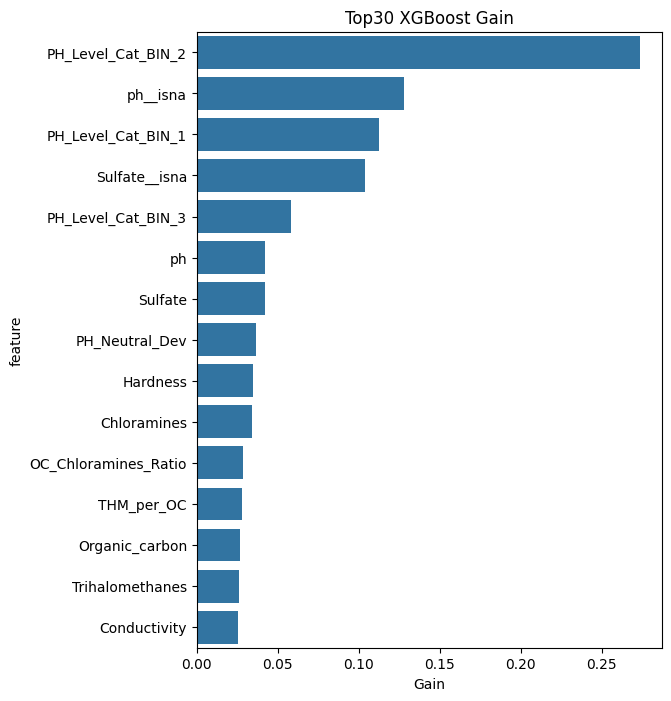

In [32]:
from utils import plot_feature_importance

feature_names = list(X_train.columns)
# ========== 特征重要性（XGBoost示例） ==========
plot_feature_importance(model=m_xgb, feature_names=feature_names)
save_exp_figure('xgb_importance.png')

In [33]:
# ------------------------------------------------------------------
# SHAP 汇总（用融合模型代表）
# ------------------------------------------------------------------
print('>>> SHAP 解释性（融合模型代表）')
explainer = shap.TreeExplainer(m_xgb)          # 可用 m_xgb / m_lgb / m_cat
sample_num = 2000  # 建议保留 sample_num 以防止全量数据导致内存溢出
X_subset = X_train.iloc[:sample_num]
shap_values_raw = explainer.shap_values(X_subset)  # 计算 SHAP 值

if isinstance(shap_values_raw, list):
    shap_values = shap_values_raw[1]
    if isinstance(explainer.expected_value, (list, np.ndarray)):
        expected_value = explainer.expected_value[1]
    else:
        expected_value = explainer.expected_value
else:
    shap_values = shap_values_raw
    expected_value = explainer.expected_value

>>> SHAP 解释性（融合模型代表）


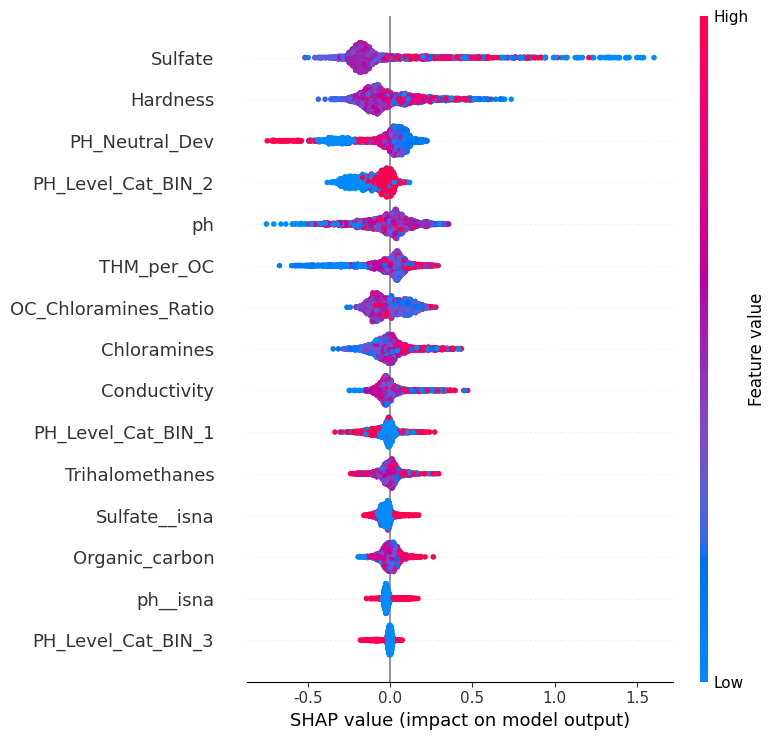

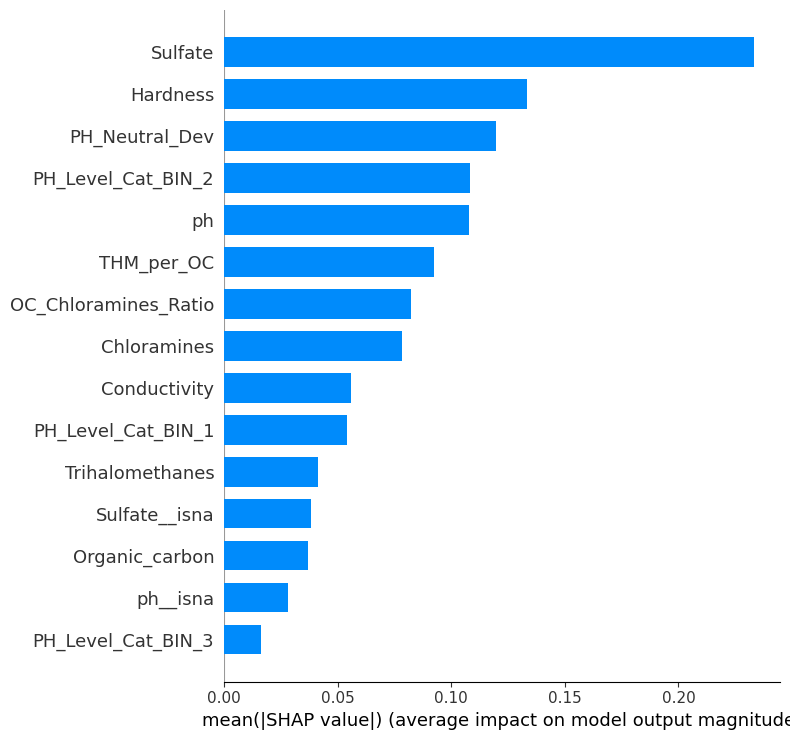

In [34]:
# === 1. 摘要图 (Summary Plot) ===
plt.figure()
shap.summary_plot(shap_values, X_subset, feature_names=feature_names, show=False)
plt.tight_layout()
# save_exp_figure("shap_summary.png", dpi=300)
save_paper_figure("fig4_shap_summary.png", dpi=300)
plt.show()
plt.close()

# === 摘要条形图 (Bar Plot) ===
plt.figure()
shap.summary_plot(shap_values, X_subset, feature_names=feature_names, plot_type="bar", show=False)
plt.tight_layout()
# save_exp_figure("shap_bar.png", dpi=300)
save_paper_figure("fig3_shap_bar.png", dpi=300)
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

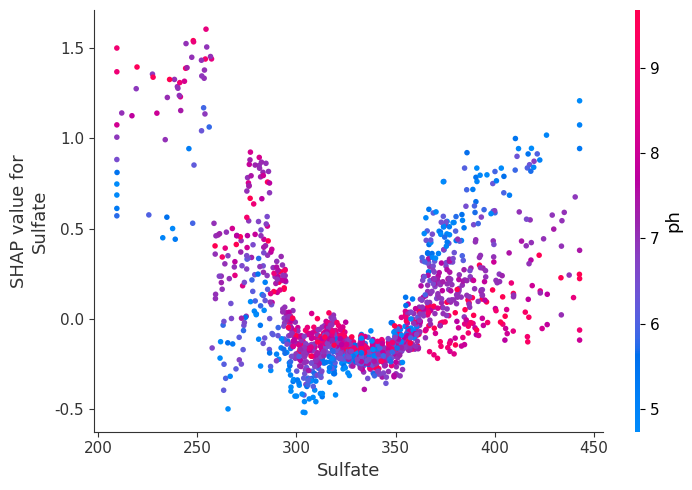

In [35]:
# === 2. SHAP 依赖图（最重要特征） ===
top_feat_idx = np.abs(shap_values).mean(0).argmax() 
plt.figure()
shap.dependence_plot(top_feat_idx, shap_values, X_subset, feature_names=feature_names, show=False)
plt.tight_layout()
# save_exp_figure("shap_dependence.png", dpi=300)
save_paper_figure("fig5_shap_dependence.png", dpi=300)
plt.show()
plt.close()

In [36]:
# === 2b. SHAP 依赖图（指定特征，可选） ===

# 例如：specified_features = ['feature_a', 'feature_b']
specified_features = []

if len(specified_features) > 0:
    specifieidxd_idx = [i for i, _ in enumerate(feature_names) if _ in specified_features]
    for fidx, fname in zip(specifieidxd_idx, specified_features):
        plt.figure()
        shap.dependence_plot(
            fidx, shap_values, X_subset,
            feature_names=feature_names, show=False
        )
        plt.tight_layout()
        save_exp_figure(f"shap_dependence_{fname}.png", dpi=300, bbox_inches='tight')
        save_paper_figure(f"shap_dependence_{fname}.png", dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()
else:
    print(">>> 未指定 SHAP dependence 特征列表，跳过 2b。")

>>> 未指定 SHAP dependence 特征列表，跳过 2b。


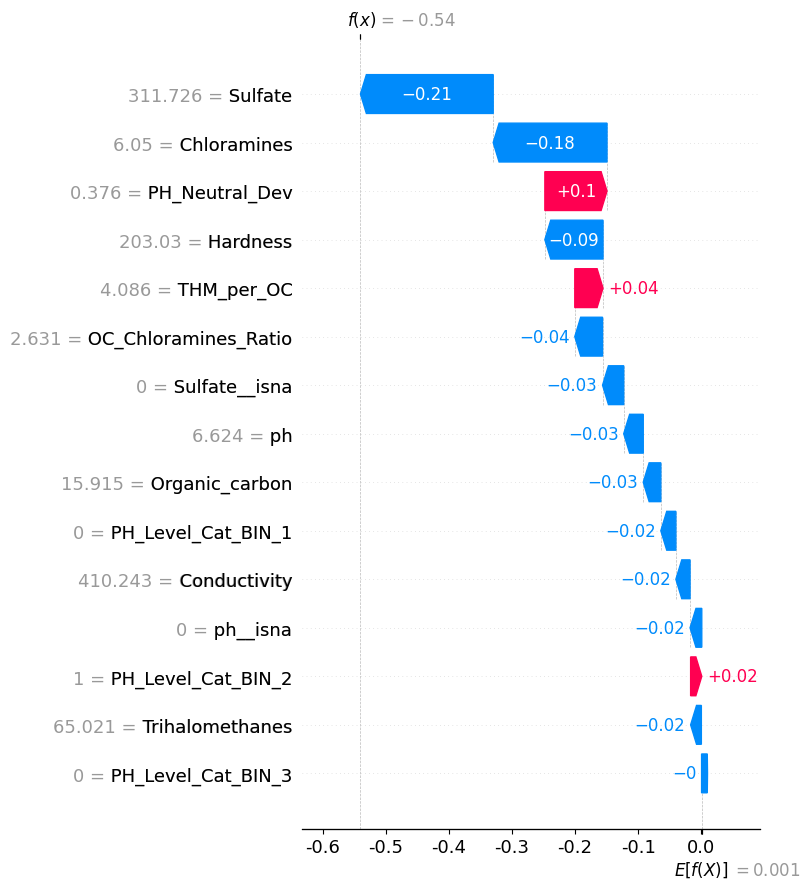

In [37]:
# === 3. SHAP 瀑布图（单样本示例） ===
sample_idx = 0 
plt.figure()
# 使用 Explanation 对象适配新版绘图接口
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[sample_idx],
        base_values=expected_value,
        data=X_subset.iloc[sample_idx],
        feature_names=feature_names
    ),
    max_display=20, show=False
)
plt.tight_layout()
save_exp_figure("shap_waterfall.png", dpi=300)
plt.show()
plt.close()